In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [5]:
def markOutliers(df,columns):

    t = np.zeros(df.shape[0])
    z = np.zeros(df.shape[0])
    for column in columns:
        mean=np.mean(df[column])
        sd=np.std(df[column])
        threshold=2
        test=[]

        for i, x in enumerate(df[column]):
            if column=="SALE_PRICE":
                if x<75000:
                    t[i]=1
            z[i]=(x-mean)/sd
            if z[i]>=threshold:
                test.append((x,z[i]))
                t[i]=1
        print(column,'\n', test)
    df['outlier']=t
    
    return df

In [6]:
def step1_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')
    # df_num_man=df.filter(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']).copy()

    #num_cols=pd.concat([num_cols,df_num_man], axis=1, join='inner')
    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)
    df[numerical]=df[numerical].replace(0, np.NaN)


    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    print(df.shape)

    df=markOutliers(df, numerical)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    print(df.shape)
    return df

In [7]:
def normalize(df,num_cols):
    #select numerical columns
    df_norm=df.copy()
    # num_cols.drop('SALE PRICE', axis='columns', inplace=True)
    df_norm[num_cols]=df_norm[num_cols]/df_norm[num_cols].abs().max()#((num_cols-num_cols.min())/(num_cols.max()-num_cols.min()))
    return df_norm

In [8]:
df = step1_clean()
df.reset_index(drop=True,inplace=True)
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
def convertNeighborhood(df):
    m = np.zeros(df.shape[0])
    dfgroup=df.groupby(by="NEIGHBORHOOD", as_index=False).mean()
    #df.groupby(by="NEIGHBORHOOD", as_index=False).mean().to_csv('groupednorm.csv')
    print(dfgroup)
    
    n=np.zeros(dfgroup.shape[0])
    for i, r in dfgroup.iterrows():
        if r["SALE_PRICE"]<.12:
            n[i]=1
        elif r["SALE_PRICE"]>.15:
            n[i]=3
        else:
            n[i]=2
    dfgroup['NCat']=n
    for i, r in df.iterrows():
        temp = dfgroup[dfgroup["NEIGHBORHOOD"]==r["NEIGHBORHOOD"]]["NCat"]
        m[i]=temp

    return m



df['lnprice']=np.log(df["SALE_PRICE"])

dfnorm=normalize(df, numerical)
dfnorm["NCat"]=convertNeighborhood(dfnorm)
df.drop(columns=['SALE_PRICE',], inplace=True)
dfnorm.drop(columns=['SALE_PRICE',], inplace=True)
numerical.remove("SALE_PRICE")

(27395, 21)
(470, 18)
RESIDENTIAL_UNITS 
 [(538.0, 11.111483409328216), (117.0, 2.0741514864081014), (522.0, 10.768021863564028), (120.0, 2.138550526238886), (397.0, 8.084728537281336), (165.0, 3.104536123700656), (188.0, 3.5982620957366716), (163.0, 3.0616034304801327), (128.0, 2.3102812991209785), (180.0, 3.4265313228545793), (209.0, 4.0490553745521645), (274.0, 5.444367904219165)]
COMMERCIAL_UNITS 
 [(63.0, 18.4892272770799), (12.0, 2.988308182553469), (17.0, 4.508006132997237), (10.0, 2.3804290023759616)]
TOTAL_UNITS 
 [(119.0, 2.036138271039512), (550.0, 11.131790234002308), (119.0, 2.036138271039512), (526.0, 10.625303813790923), (125.0, 2.1627598760923585), (398.0, 7.924042905996868), (173.0, 3.175732716515129), (195.0, 3.6400119350422324), (165.0, 3.0069039097780004), (130.0, 2.2682778803030637), (181.0, 3.3445615232522576), (213.0, 4.019876750200772), (277.0, 5.370507204097799)]
LAND_SQUARE_FEET 
 [(150322.0, 18.199846915126173), (35373.0, 3.882155805469149), (40873.0, 4.56721

C:\Users\zacha\AppData\Local\Temp\ipykernel_37864\3514827983.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfgroup=df.groupby(by="NEIGHBORHOOD", as_index=False).mean()


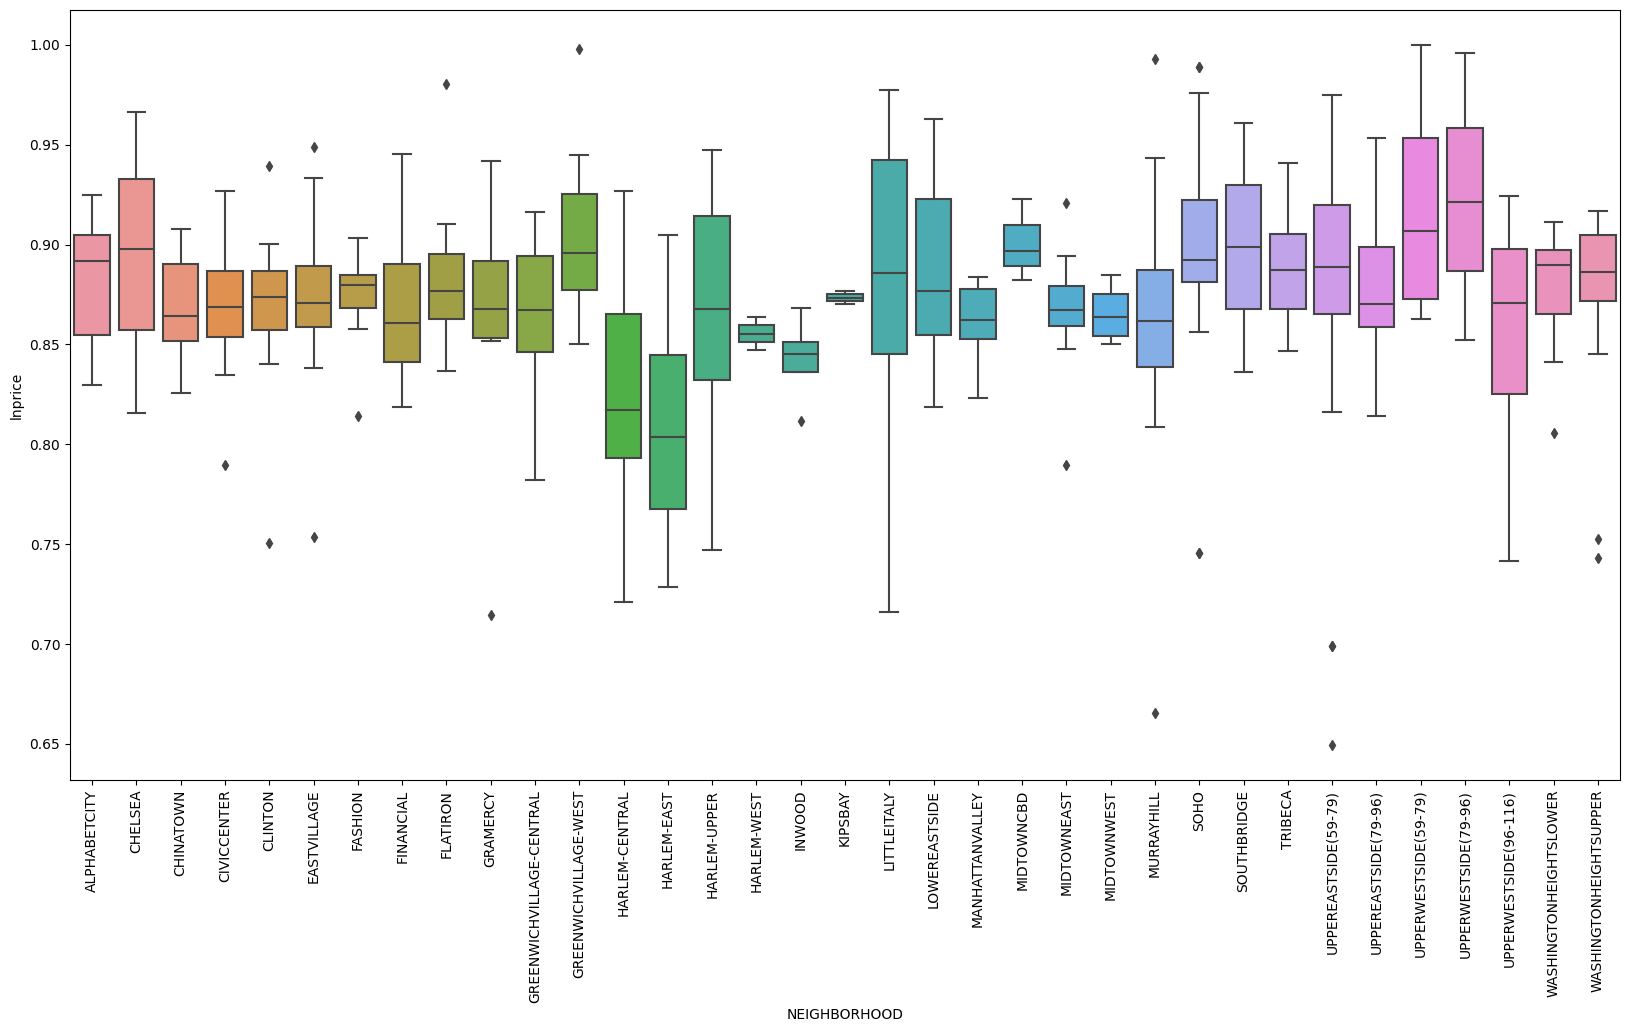

In [331]:
plt.figure(figsize=[20,10])
sns.boxplot( y=dfnorm["lnprice"], x=dfnorm["NEIGHBORHOOD"] )
plt.xticks(rotation=90)
plt.show()


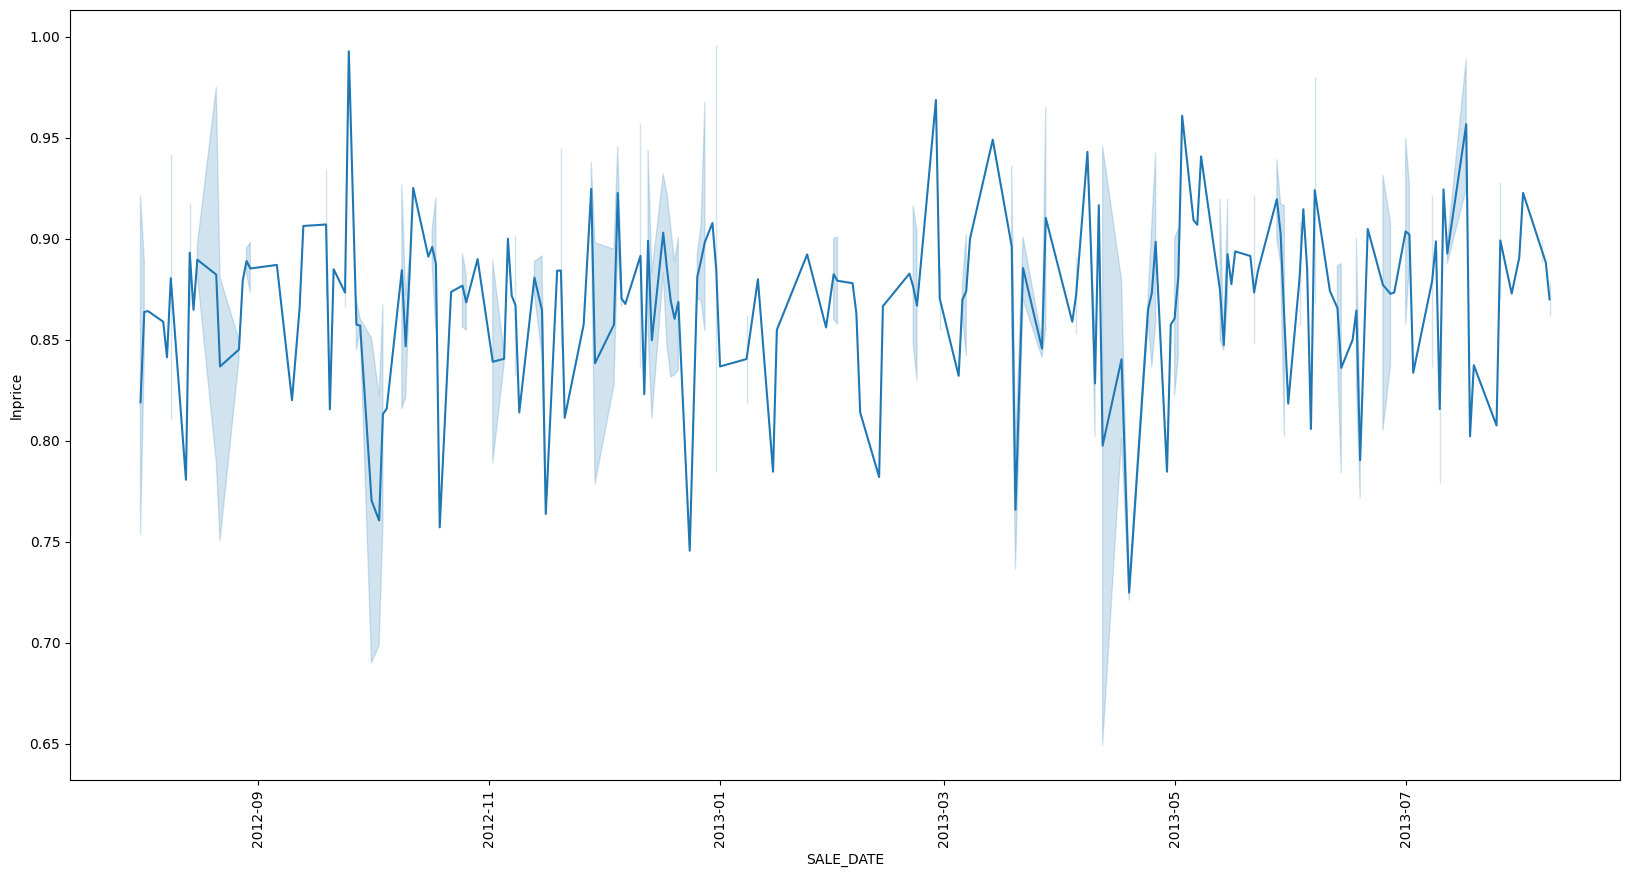

In [332]:
fig, axes=plt.subplots(figsize=[20,10])
sns.lineplot(y="lnprice", x="SALE_DATE", data=dfnorm)
plt.xticks(rotation = 'vertical')
plt.show()


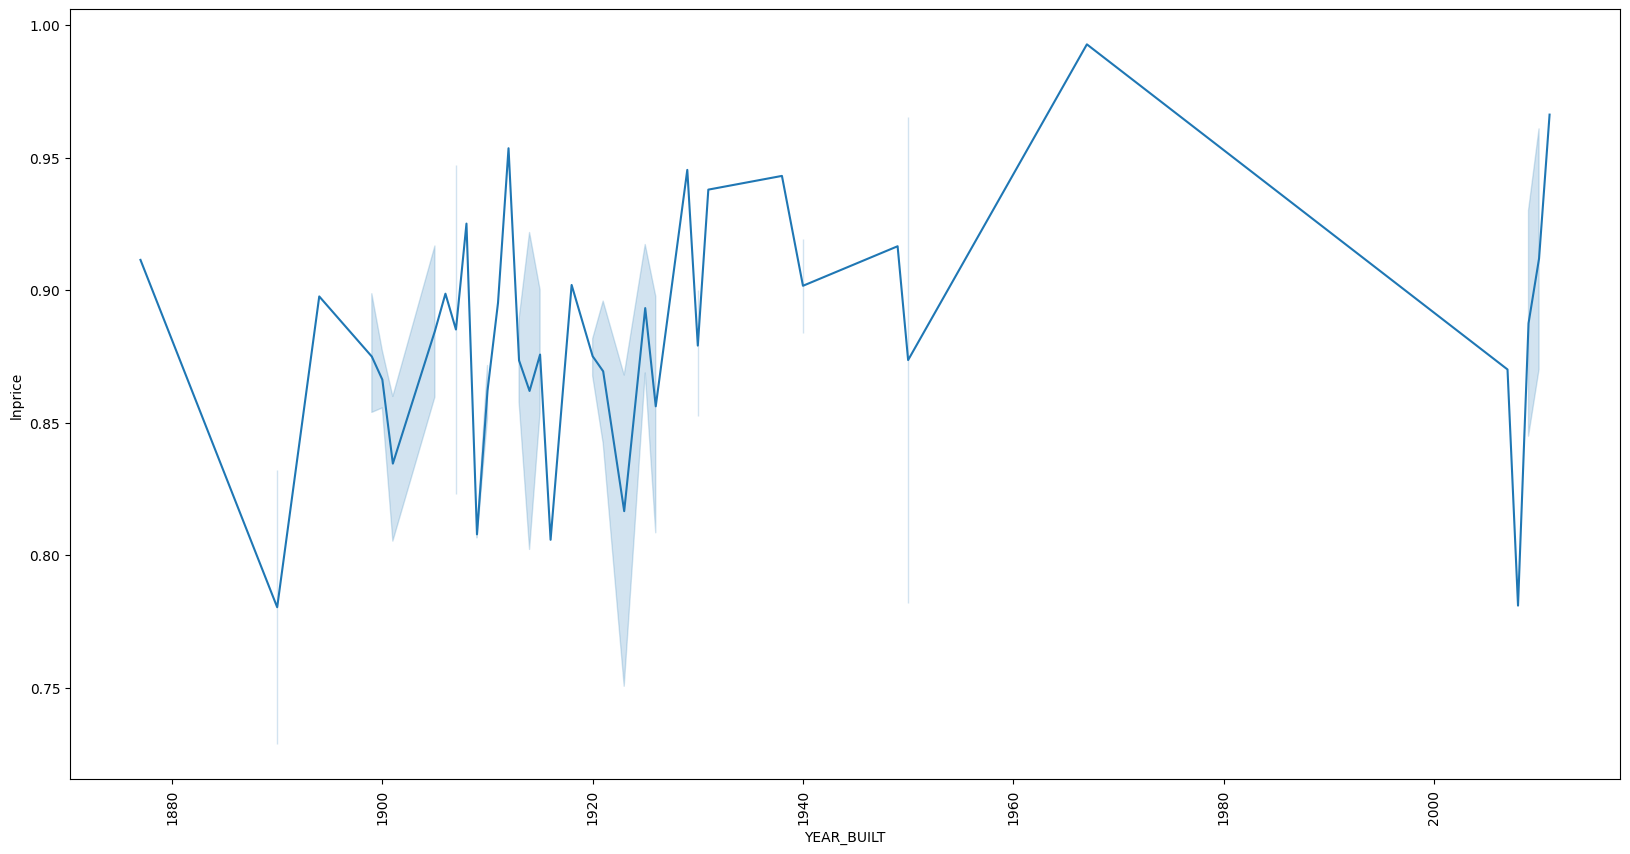

In [333]:
fig, axes=plt.subplots(figsize=[20,10])
sns.lineplot(y="lnprice", x="YEAR_BUILT", data=dfnorm)
plt.xticks(rotation = 'vertical')
plt.show()

C:\Users\zacha\AppData\Local\Temp\ipykernel_3088\2831284990.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  matrix=scatter_matrix(dfnorm, alpha=0.3, diagonal='kde', ax = ax)


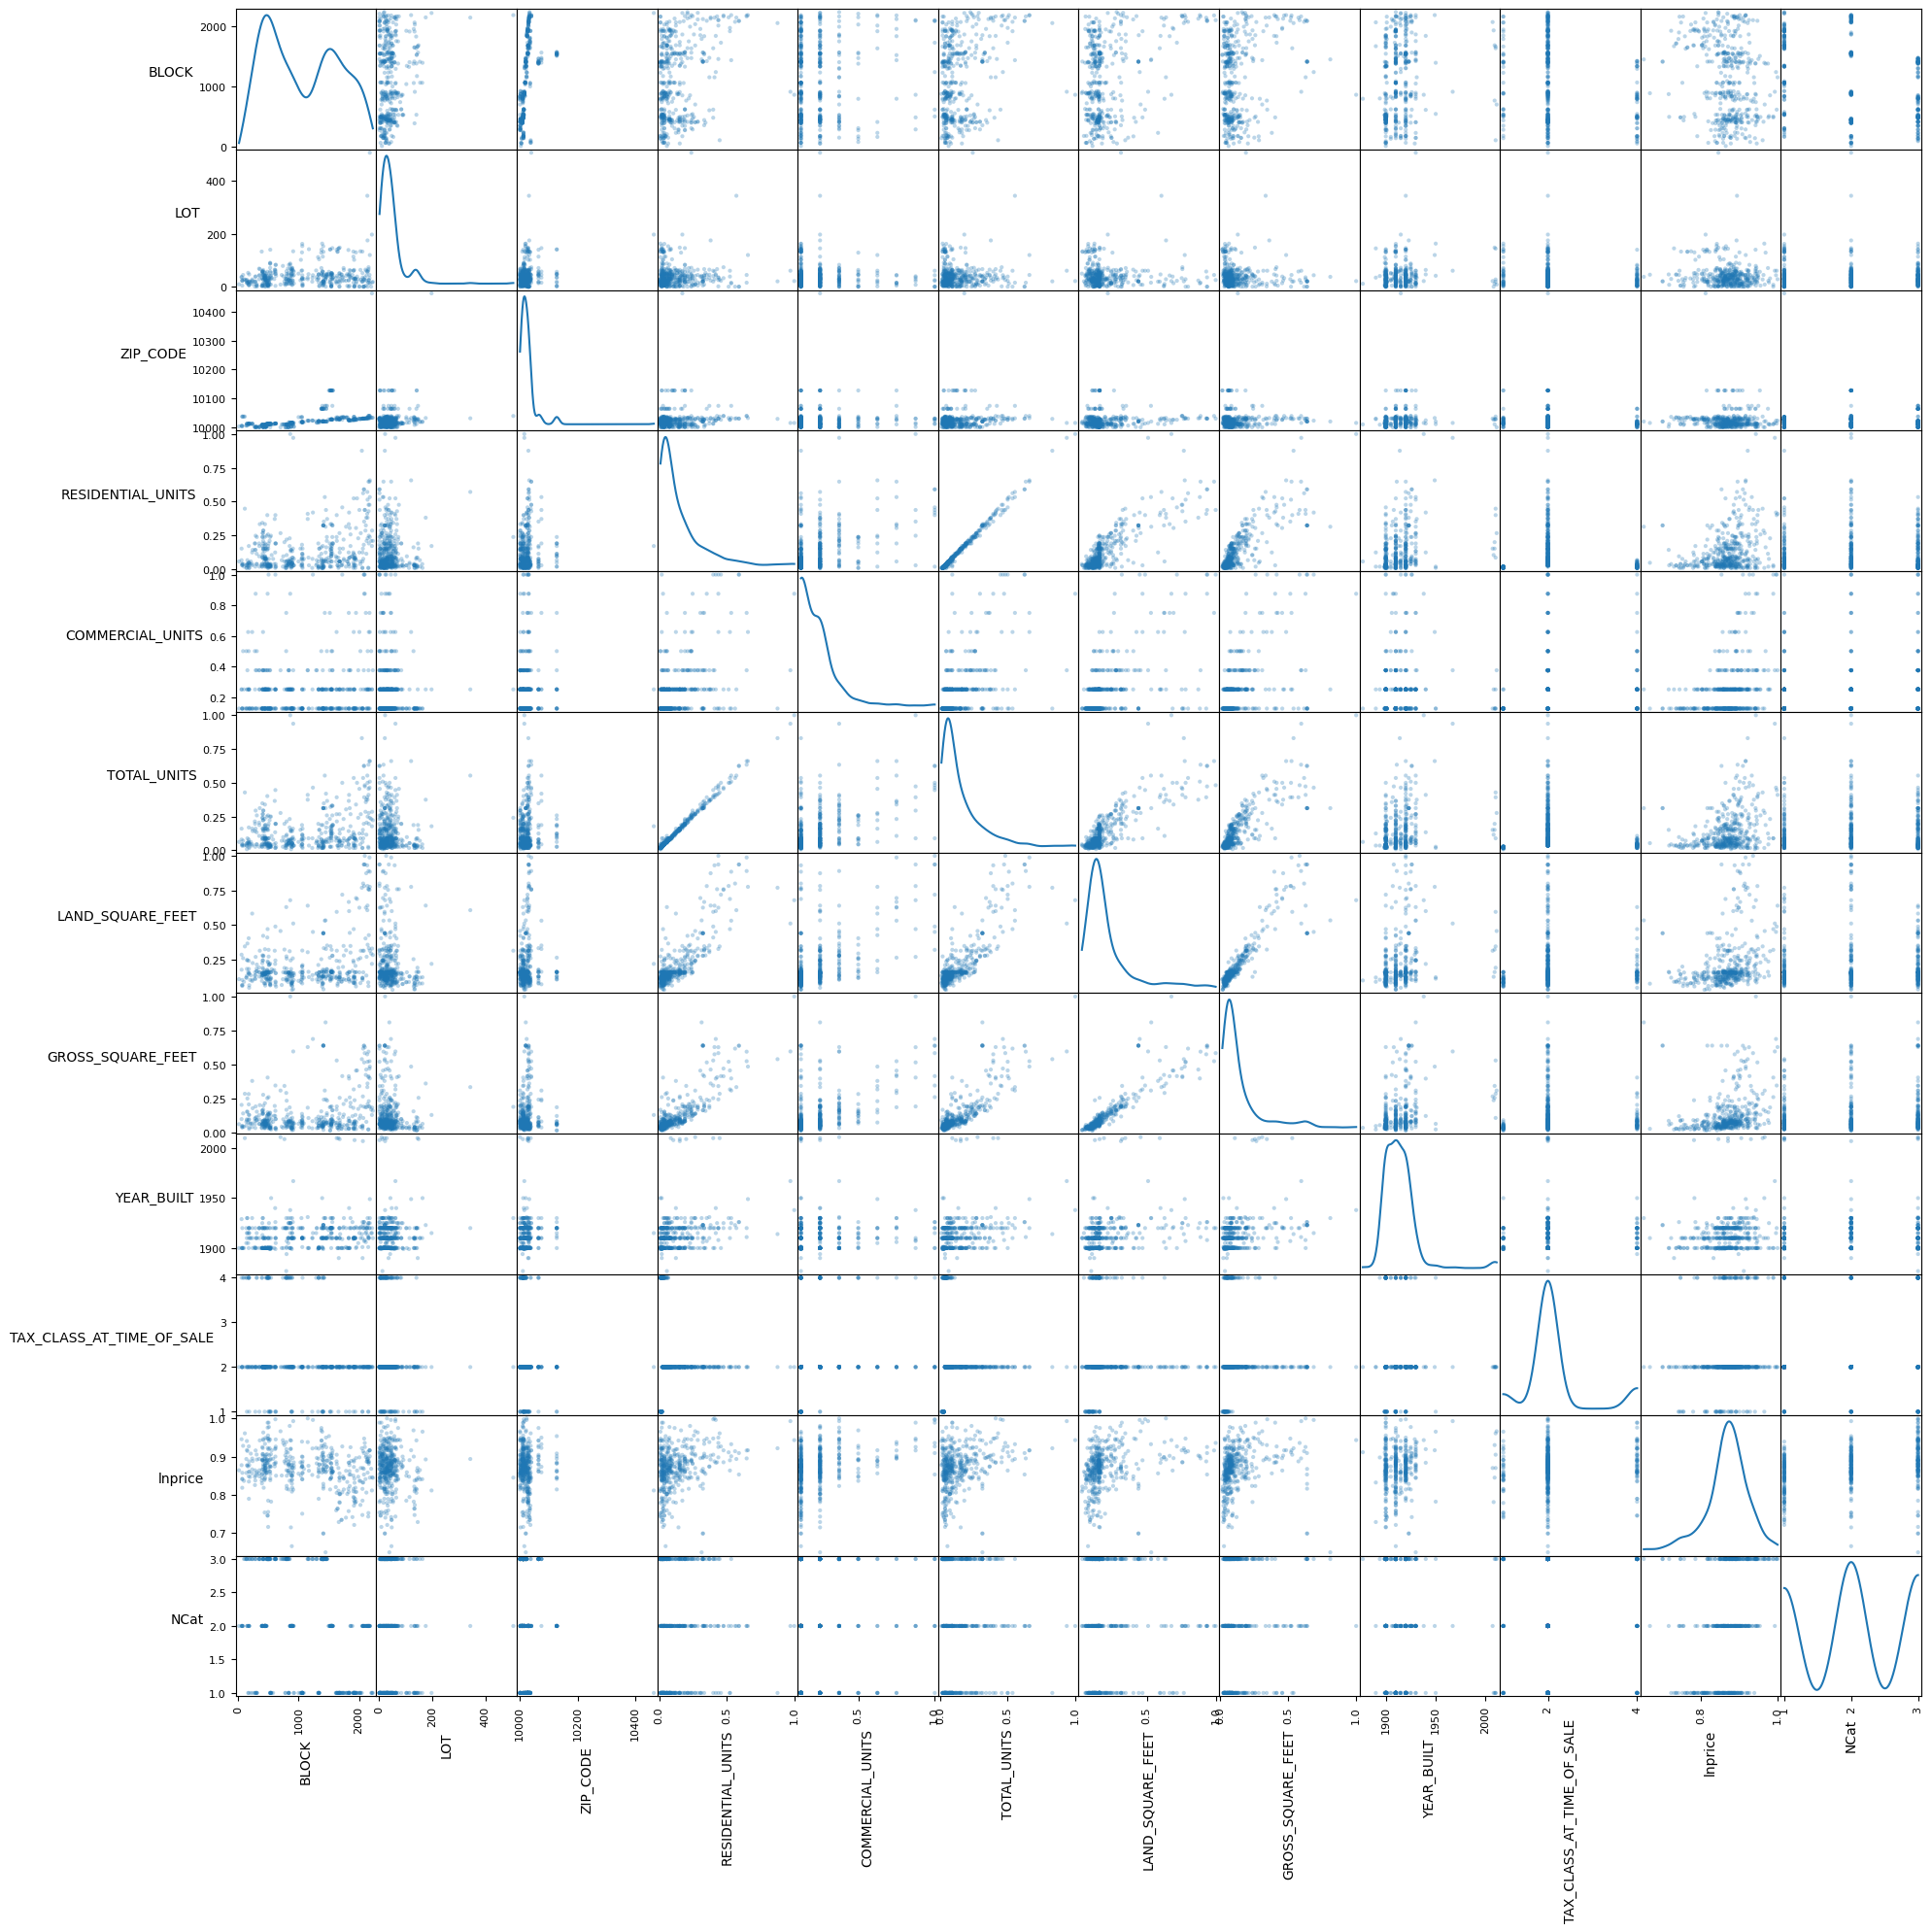

In [334]:
fig = plt.figure(1, figsize=[20, 20])
fig.clf()
ax = fig.gca()
matrix=scatter_matrix(dfnorm, alpha=0.3, diagonal='kde', ax = ax)
for ax in matrix.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()


C:\Users\zacha\AppData\Local\Temp\ipykernel_3088\3470296617.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(dfnorm.corr(), vmin=-1, vmax=1, annot=True)


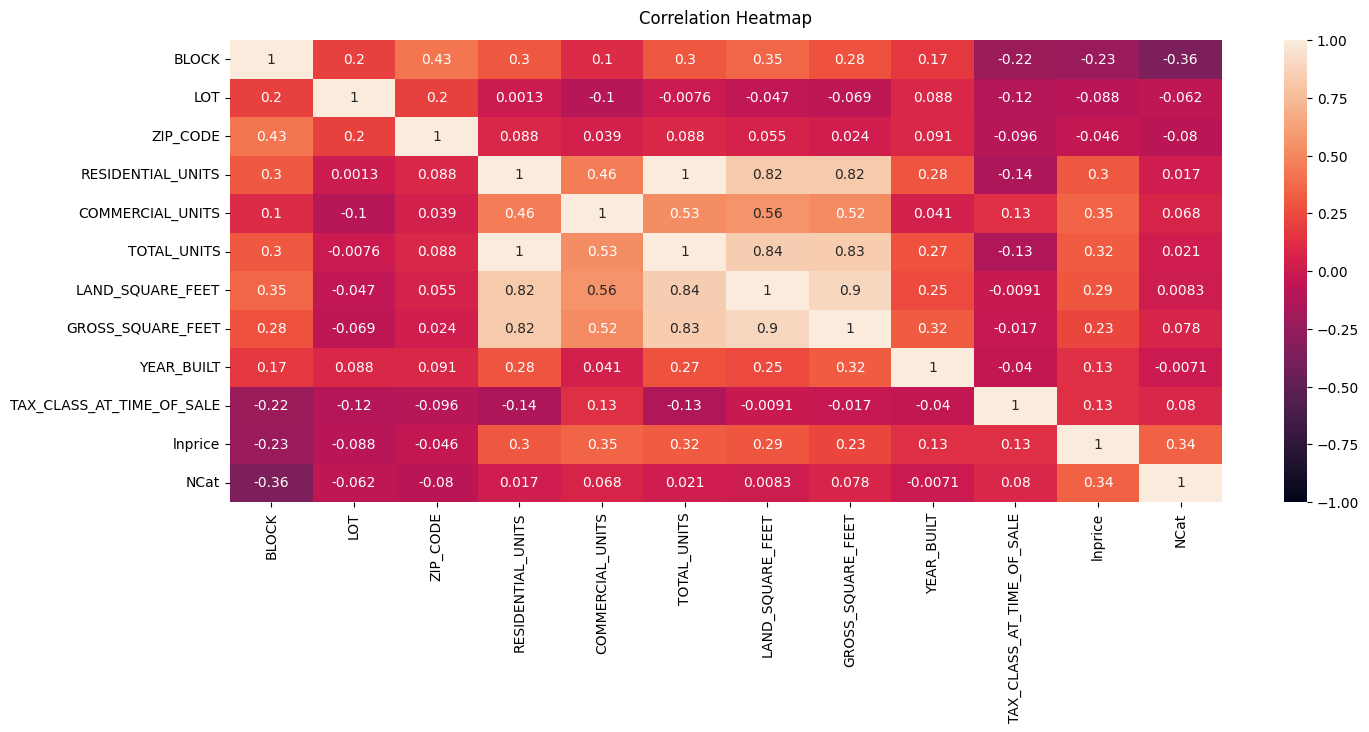

In [335]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfnorm.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [336]:
def regressionFitNumerical(df, column):
#     d = np.polyfit(df[column],df['lnprice'],1)
#     f = np.poly1d(d)
#     dfreg=df.copy()
#     dfreg.insert(len(dfreg.columns), 'reg', f(dfreg[column]))
#     ax=dfreg.plot.scatter(y="lnprice", x=column)
#     dfreg.plot(y="reg", x=column, color='Red', legend=False, ax=ax)

    f='lnprice~'+column
    model = smf.ols(formula=f, data=df).fit()
    predicted=model.predict(df[column])
    plt.plot(df[column],df["lnprice"], 'bo')
    plt.plot(df[column], predicted, 'r-', linewidth=2)
    #plt.title('Linear Regression Fit')
    plt.show()
    print('\n',model.params)
    print("confidence interval:\n", model.conf_int(alpha=0.05),'\n')
    print("P values:\n", model.pvalues)
    print("R-Squared", model.rsquared)

# def regressionFitCategorical(df, column):
# #     d = np.polyfit(df[column],df['lnprice'],1)
# #     f = np.poly1d(d)
# #     dfreg=df.copy()
# #     dfreg.insert(len(dfreg.columns), 'reg', f(dfreg[column]))
# #     ax=dfreg.plot.scatter(y="lnprice", x=column)
# #     dfreg.plot(y="reg", x=column, color='Red', legend=False, ax=ax)


#     model = smf.ols(formula=f, data=df).fit()
#     predicted=model.predict(df[column])
#     plt.plot(df[column],df["lnprice"], 'bo')
#     plt.plot(df[column], predicted, 'r-', linewidth=2)
#     #plt.title('Linear Regression Fit')
#     plt.show()
#     print('\n',model.params)
#     print("confidence interval:\n", model.conf_int(alpha=0.05),'\n')
#     print("P values:\n", model.pvalues)
#     print("R-Squared", model.rsquared)


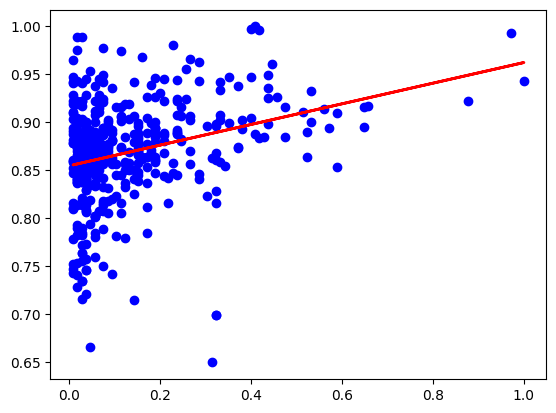


 Intercept            0.854553
RESIDENTIAL_UNITS    0.107848
dtype: float64
confidence interval:
                           0         1
Intercept          0.848093  0.861014
RESIDENTIAL_UNITS  0.075430  0.140266 

P values:
 Intercept            0.000000e+00
RESIDENTIAL_UNITS    1.741408e-10
dtype: float64
R-Squared 0.08929869122266154


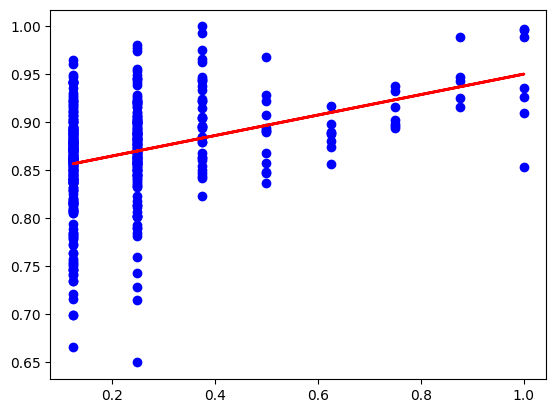


 Intercept           0.843370
COMMERCIAL_UNITS    0.106978
dtype: float64
confidence interval:
                          0         1
Intercept         0.835416  0.851324
COMMERCIAL_UNITS  0.080156  0.133800 

P values:
 Intercept           0.000000e+00
COMMERCIAL_UNITS    3.516464e-14
dtype: float64
R-Squared 0.12352873782244611


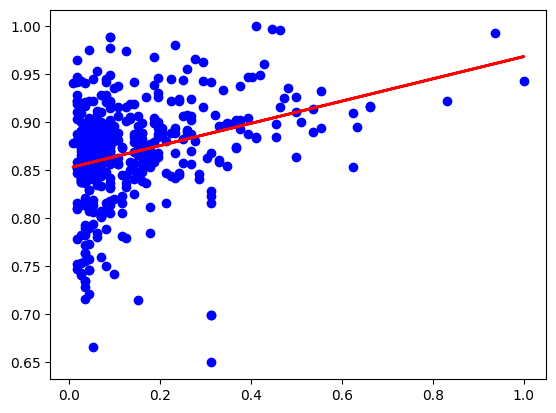


 Intercept      0.852457
TOTAL_UNITS    0.116199
dtype: float64
confidence interval:
                     0         1
Intercept    0.845781  0.859133
TOTAL_UNITS  0.083292  0.149106 

P values:
 Intercept      0.000000e+00
TOTAL_UNITS    1.424988e-11
dtype: float64
R-Squared 0.09948248539997673


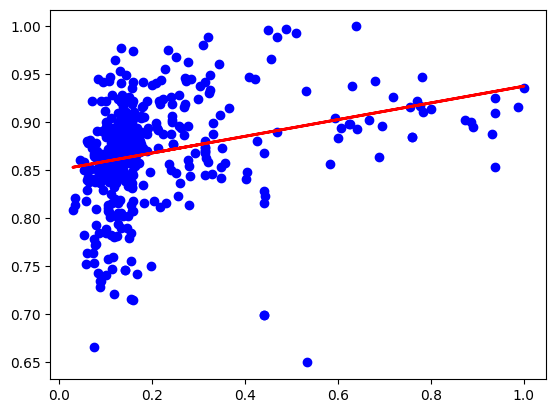


 Intercept           0.850579
LAND_SQUARE_FEET    0.087145
dtype: float64
confidence interval:
                          0         1
Intercept         0.843140  0.858018
LAND_SQUARE_FEET  0.060213  0.114077 

P values:
 Intercept           0.000000e+00
LAND_SQUARE_FEET    5.112730e-10
dtype: float64
R-Squared 0.08488947347893927


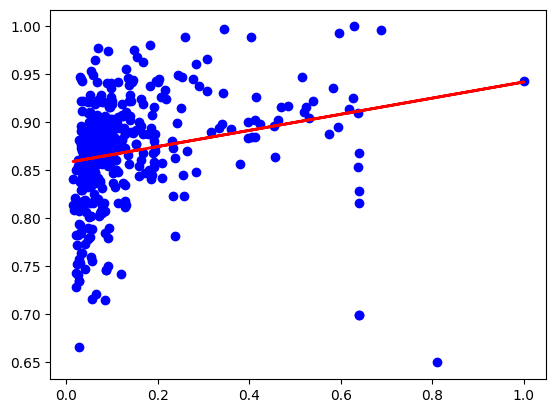


 Intercept            0.857896
GROSS_SQUARE_FEET    0.084235
dtype: float64
confidence interval:
                           0         1
Intercept          0.851298  0.864494
GROSS_SQUARE_FEET  0.050488  0.117981 

P values:
 Intercept            0.000000
GROSS_SQUARE_FEET    0.000001
dtype: float64
R-Squared 0.05231403568947268


In [337]:
#numerical.remove("SALE_PRICE")
for col in numerical:
    if col=="lnprice":
        continue

    regressionFitNumerical(dfnorm, col)



In [88]:

# XO=dfnorm[feature_cols]
# YO=dfnorm['lnprice']
# # est=svm.SVR(kernel="linear")
# # sel= feature_selection.RFE(est, n_features_to_select=7, step=1)
# # sel = sel.fit(XO, YO)
# # select_features = np.array(feature_cols)[sel.ranking_==1].tolist()
# # print(select_features)
# # X = dfnorm[select_features]

select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
        'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'NEIGHBORHOOD']
# Select predictors
X = dfnorm[select_features]

# Encode categorical variables using one-hot encoding
X = pd.get_dummies(X)

# Target variable
Y = dfnorm['lnprice']
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
lm = linear_model.LinearRegression()
lm.fit(trainX, trainY)
print("Y-axis intercept {:6.4f}".format(lm.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, lm.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(lm.score(trainX,
trainY)))
print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))

Y-axis intercept -0.2373
Weight coefficients:
    RESIDENTIAL_UNITS: 1.9418
     COMMERCIAL_UNITS: 0.2198
          TOTAL_UNITS: -1.9577
     LAND_SQUARE_FEET: 0.1694
    GROSS_SQUARE_FEET: -0.2249
           YEAR_BUILT: 0.0006
         NEIGHBORHOOD: -0.0030
R squared for the training data is 0.454
Score against test data: 0.336


In [84]:
def mse(df, pred, obs):
    n = df.shape[0]
    return sum((df[pred]-df[obs])**2)/n
#dfnorm['pred'] = lm.predict(X)
print("Mean Squared error: {}".format(mse(dfnorm,'pred', 'lnprice')))

Mean Squared error: 0.0016143974855050353


Score against test data: -0.009


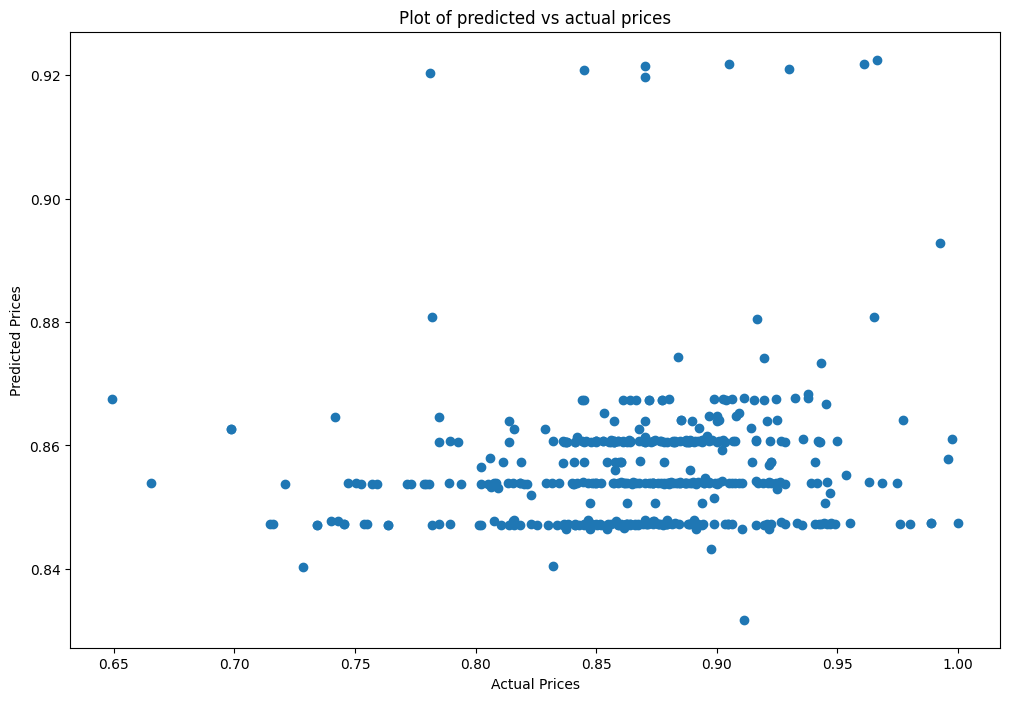

In [89]:

rbf = svm.SVR(kernel="rbf", C=1e2, tol=1e-4)
rbf.fit(trainX, trainY)
print("Score against test data: {:4.3f}".format(rbf.score(testX, testY)))

# Make predictions with SVM model
dfnorm_X = pd.get_dummies(dfnorm[select_features])
#dfnorm_X = scaler.transform(dfnorm_X)
predicted = rbf.predict(dfnorm_X)

# Plot predicted vs actual prices
plt.figure(figsize=(12, 8))
plt.scatter(dfnorm['lnprice'], predicted)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Plot of predicted vs actual prices")
plt.show()

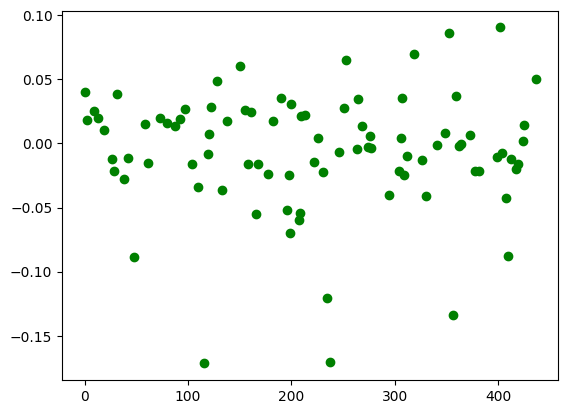

In [90]:
pred=lm.predict(testX)
res=(testY-pred)
plt.plot(res, 'go')
plt.show()

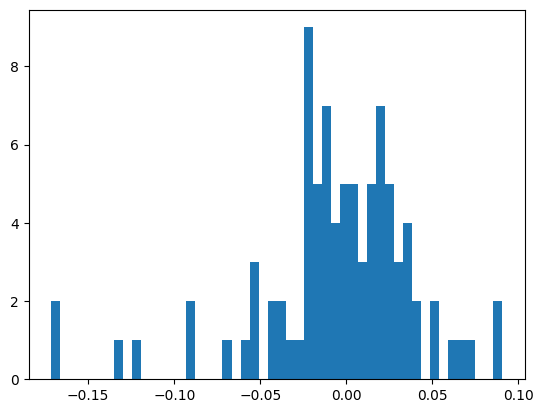

In [91]:
plt.hist(res, bins=50)
plt.show()

In [92]:
RSEd = ((testY-pred)**2).sum()
RSE = np.sqrt(RSEd/(dfnorm.shape[0]-1-1))
RSE

0.020875835887350345

In [95]:
x=dfnorm[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'NCat', 'YEAR_BUILT']]
y=dfnorm['lnprice']
model=sm.OLS(y,x).fit()
print(model.summary())

KeyError: "['C(NEIGHBORHOOD)'] not in index"

Root Mean Squared Error: 5912485.52
Cross-validation scores:  [ 1.79865216e-01  3.49385832e-01 -3.16454709e-01  2.27006178e-01
 -3.33894198e-04]
Mean cross-validation score: 0.09
Y-axis intercept -72306694.8952
Weight coefficients:
    RESIDENTIAL_UNITS: 2085627.4791
     COMMERCIAL_UNITS: 3455274.2970
          TOTAL_UNITS: -2061926.0873
     LAND_SQUARE_FEET: 781.4491
    GROSS_SQUARE_FEET: -41.1081
           YEAR_BUILT: 38970.4941
         NEIGHBORHOOD: -571097.5813
R squared for the training data is 0.403
Score against test data: 0.321


<Axes: xlabel='SALE_PRICE', ylabel='Count'>

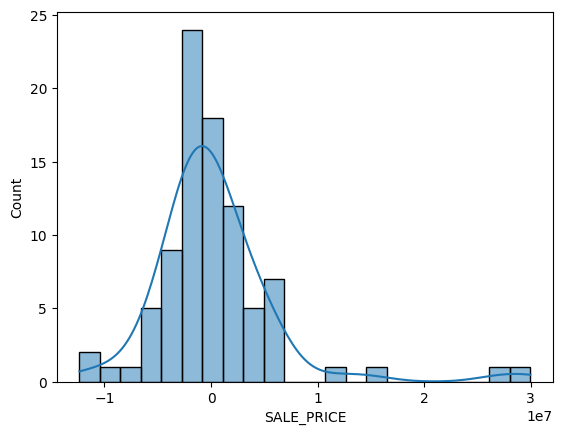

In [20]:
# Load the cleaned dataset

select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
        'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'NEIGHBORHOOD']
# Select predictors
X = df[select_features]

# Encode categorical variables using one-hot encoding
X = pd.get_dummies(X)

# Target variable
y = df['SALE_PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Y-axis intercept {:6.4f}".format(model.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, model.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train,
y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

# Plot histogram of residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)